In [2]:
!pip install astropy

     |████████████████████████████████| 6.5 MB 3.7 MB/s eta 0:00:01


In [7]:
from astropy.io import fits
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import impute

In [62]:
import torch
from torch import nn
from torch.autograd import Variable

In [8]:
# открыть файлы с скрасными смещениями

data = fits.open('http://gal-03.sai.msu.ru/~vtoptun/photometry/rcsed_v2_clean.fits')

data.info()

Filename: /root/.astropy/cache/download/py3/0508754bf44ea7119c5b6b1a661568ef
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (73531,)   uint8   
  1  Joined        1 BinTableHDU   1644   4105516R x 559C   [J, D, D, D, D, D, K, I, J, I, E, J, 6A, D, I, 15A, J, J, D, D, D, D, E, E, E, J, J, J, 40A, B, B, E, I, I, 10A, E, J, E, J, E, I, 14A, E, I, 33A, L, L, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E, E, E, E, D, D, D, D, D, E, E, E, E, E, D, D, D, D, D, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, E, E, D, E, D, E, D, E, D, E, D, E, D, E, D, E, D, E, D, E, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [80]:
GrID = pd.read_csv('rcsed_iGrID.csv')

In [9]:
data = data[1].data

In [74]:
cols = data.columns.names #559

In [75]:
# конвертация в датафрейм
RCSED_V2 = pd.DataFrame(np.array(data).byteswap().newbyteorder())
display(RCSED_V2.head())

,ind,ra,dec,z_sdss,zerr_sdss,specObjID_sdss,bestObjID_sdss,plate_sdss,mjd_sdss,fiberID_sdss,...,expRadErr_g,expAB_g,expABErr_g,expPhi_g,expMag_g,expFlux_g,expFluxIvar_g,expMagErr_g,modelMag_g,modelMagErr_g
0,1,0.000019,-4.760800,2.467120,0.002194,7.919679e+18,0,7034,56564,360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.000091,24.902252,0.555936,0.000245,7.333218e+18,1237666309095751941,6513,56543,843,...,11.760200,0.249997,0.369362,83.70193,22.08381,1.461627,1.991625,0.522415,23.18259,0.386604
2,3,0.000346,-6.491940,0.514177,0.000130,8.047035e+18,1237680243597902184,7147,56574,831,...,1.559838,0.147778,0.201906,84.34074,21.86258,1.794235,11.132140,0.180460,21.12392,0.183285
3,4,0.000463,10.241074,0.654380,0.000170,6.960408e+18,1237679319089349467,6182,56190,346,...,2.020618,0.265576,0.520042,43.52781,22.94896,0.649079,20.061290,0.359881,23.39049,0.270960
4,5,0.000559,34.985602,0.146326,0.000021,8.044630e+18,1237666184574271705,7145,56567,274,...,0.037337,0.722592,0.026249,126.50180,18.75811,31.387160,12.734440,0.009693,18.37597,0.009515


In [137]:
RCSED_V2.ind

0                1
1                2
2                3
3                4
4                5
            ...   
4105511    4240799
4105512    4240800
4105513    4240801
4105514    4240802
4105515    4240803
Name: ind, Length: 4105516, dtype: int32

In [76]:
ID_cols = list(RCSED_V2.filter(regex='ID'))

In [77]:
#ID_cols.append('ind')
ID_cols.append('recno_uzc')

In [78]:
ID_cols

['specObjID_sdss',
 'bestObjID_sdss',
 'fiberID_sdss',
 'SPECT_ID_lega_c',
 'SPECID_gama',
 'recno_uzc']

In [79]:
RCSED_V2 = RCSED_V2[RCSED_V2.columns.drop(ID_cols)]

In [81]:
cat_cols = ['SpecFile_wigglez', 'targetname_6df', 'SeqNum_2df', 'planid_lamost']

In [82]:
RCSED_V2 = RCSED_V2[RCSED_V2.columns.drop(cat_cols)]

In [83]:
len(RCSED_V2.columns)

549

In [84]:
RCSED_V2.head()

,ind,ra,dec,z_sdss,zerr_sdss,plate_sdss,mjd_sdss,z_2df,q_z_2df,z_6df,...,expRadErr_g,expAB_g,expABErr_g,expPhi_g,expMag_g,expFlux_g,expFluxIvar_g,expMagErr_g,modelMag_g,modelMagErr_g
0,1,0.000019,-4.760800,2.467120,0.002194,7034,56564,NaN,-2147483648,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.000091,24.902252,0.555936,0.000245,6513,56543,NaN,-2147483648,NaN,...,11.760200,0.249997,0.369362,83.70193,22.08381,1.461627,1.991625,0.522415,23.18259,0.386604
2,3,0.000346,-6.491940,0.514177,0.000130,7147,56574,NaN,-2147483648,NaN,...,1.559838,0.147778,0.201906,84.34074,21.86258,1.794235,11.132140,0.180460,21.12392,0.183285
3,4,0.000463,10.241074,0.654380,0.000170,6182,56190,NaN,-2147483648,NaN,...,2.020618,0.265576,0.520042,43.52781,22.94896,0.649079,20.061290,0.359881,23.39049,0.270960
4,5,0.000559,34.985602,0.146326,0.000021,7145,56567,NaN,-2147483648,NaN,...,0.037337,0.722592,0.026249,126.50180,18.75811,31.387160,12.734440,0.009693,18.37597,0.009515


In [85]:
len_data = len(RCSED_V2)

In [86]:
len_data

4105516

In [22]:
sum(np.array(RCSED_V2.OBJNO_deep2) != -2147483648) / len_data

0.008394316329542986

In [23]:
#replace NaN

In [87]:
def null_treating(cols, null):
    for col in cols:
        if sum(np.array(RCSED_V2[col]) == null) / len(RCSED_V2) > 0.9:
            RCSED_V2.drop([col],axis=1, inplace=True)
            cols.remove(col)
        else:
            RCSED_V2[col].replace(null, np.nan) 

In [88]:
#null = -2147483648
cols_NaN1 = ['mjd_sdss', 'q_z_2df', 'specid_6df', 'obsid_lamost', 'lmjd_lamost', 'mjd_lamost',
             'OBJNO_deep2', 'OBJNO_deep3']

In [89]:
#null = -32768
cols_NaN2 = ['plate_sdss', 'quality_6df', 'f_z_lega_c', 'Q_wigglez', 'NQ_gama']

In [90]:
#null = 255
cols_NaN3 = ['spid_lamost', 'fiberid_lamost']

In [91]:
null_treating(cols_NaN1, -2147483648)

In [92]:
null_treating(cols_NaN2, -32768)

In [93]:
null_treating(cols_NaN3, 255)

In [94]:
len(RCSED_V2.columns)

542

In [95]:
#  Anomaly detection

top_values = []
nan = []

for col in RCSED_V2.columns:
    vc = RCSED_V2[col].value_counts(ascending=False).head(1)
    nan = (RCSED_V2[col].isna()).sum()
    total = nan
    if vc[vc.index[0]] >1000:
        total = vc[vc.index[0]]+nan
    top_values.append([vc.name, vc.index[0], vc[vc.index[0]], nan, total])
    
anomaly = pd.DataFrame(data=top_values, columns = ['column_name', 'anomaly_value', 'value_counts', 'nan', 'total'])

In [96]:
anomaly.sort_values(by='total', ascending=False)[1:20]

,column_name,anomaly_value,value_counts,nan,total
228,KSERMAG2D_ukidss,-9.999995e+08,1070222,3035294,4105516
226,KPSFMAG_ukidss,-9.999995e+08,1070222,3035294,4105516
229,KSERMAG2DERR_ukidss,-9.999995e+08,1070222,3035294,4105516
13,z_err_cfa,0.000000e+00,40726,4064789,4105515
11,z_err_uzc,0.000000e+00,19372,4086143,4105515
19,z_lega_c,7.282000e-01,5,4103710,4103710
21,f_spec_lega_c,-3.276800e+04,4103699,0,4103699
20,f_z_lega_c,-3.276800e+04,4103699,0,4103699
24,Z_deep3,5.334126e-01,4,4098346,4098346
167,e_v_petro_skymapper,1.340000e-01,48,4098322,4098322


In [97]:
#4105516*0.9 = 3694964

col_anomaly = anomaly[anomaly.total>3694964].column_name.to_list()

In [98]:
len(col_anomaly)

194

In [99]:
RCSED_V2.drop(col_anomaly, axis=1, inplace=True)

In [100]:
len(RCSED_V2.columns)

348

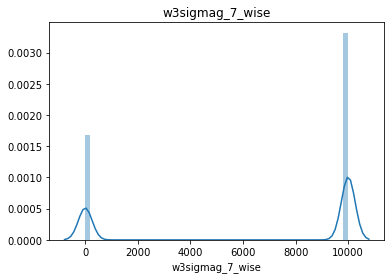

In [38]:
sns.distplot(RCSED_V2.w3sigmag_7_wise)
plt.title('w3sigmag_7_wise')
plt.show()

In [40]:
len(np.unique(RCSED_V2.w3sigmag_7_wise))-2202889

540

**To do**
*IterativeImputer*
-> models each feature with missing values as a function of other features, and uses that estimate for imputation

In [46]:
len(np.unique(RCSED_V2.KAPERMAG3ERR_ukidss))-2967341

1029677

In [101]:
col_for_nan = anomaly2.sort_values(by='total', ascending=False)[1:149].column_name.to_list()
col_anomaly = anomaly2.sort_values(by='total', ascending=False)[1:149].anomaly_value.to_list()

In [102]:
for col, anomaly in zip(col_for_nan, col_anomaly):
    RCSED_V2[col].replace(anomaly, np.nan)

In [103]:
data_0 = RCSED_V2.fillna(0)

In [104]:
data_0

,ind,ra,dec,z_sdss,zerr_sdss,plate_sdss,mjd_sdss,E_bv,A_u_sdss,A_g_sdss,...,expRadErr_g,expAB_g,expABErr_g,expPhi_g,expMag_g,expFlux_g,expFluxIvar_g,expMagErr_g,modelMag_g,modelMagErr_g
0,1,0.000019,-4.760800,2.467120,0.002194,7034,56564,0.032031,0.135779,0.105798,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
1,2,0.000091,24.902252,0.555936,0.000245,6513,56543,0.081351,0.344846,0.268702,...,11.760200,0.249997,0.369362,83.70193,22.08381,1.461627,1.991625,0.522415,23.18259,0.386604
2,3,0.000346,-6.491940,0.514177,0.000130,7147,56574,0.037788,0.160183,0.124814,...,1.559838,0.147778,0.201906,84.34074,21.86258,1.794235,11.132140,0.180460,21.12392,0.183285
3,4,0.000463,10.241074,0.654380,0.000170,6182,56190,0.087513,0.370967,0.289055,...,2.020618,0.265576,0.520042,43.52781,22.94896,0.649079,20.061290,0.359881,23.39049,0.270960
4,5,0.000559,34.985602,0.146326,0.000021,7145,56567,0.077543,0.328706,0.256126,...,0.037337,0.722592,0.026249,126.50180,18.75811,31.387160,12.734440,0.009693,18.37597,0.009515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105511,4240799,359.999290,34.720838,3.113524,0.000393,7145,56567,0.079144,0.335492,0.261413,...,0.096093,0.999857,0.214987,183.73740,20.40784,6.867387,60.197580,0.020370,20.42196,0.019423
4105512,4240800,359.999620,3.268586,1.233161,0.000179,8741,57390,0.023462,0.099455,0.077495,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
4105513,4240801,359.999760,20.721079,2.009941,0.000532,7595,56957,0.067442,0.285888,0.222762,...,0.098074,0.745419,0.654953,96.35545,20.30583,7.544051,31.594700,0.025597,20.33737,0.022423
4105514,4240802,359.999786,-35.213409,0.000000,0.000000,-32768,-2147483648,0.012461,0.052821,0.041158,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000


In [105]:
data_0 = data_0.replace([np.inf, -np.inf], np.nan).fillna(0)

# Labeled part of data

In [106]:
GrID.head()

,iGrID
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [109]:
len(GrID)

4105516

In [124]:
sdss_indx = GrID[-GrID.iGrID.isna()].index.to_list()

In [126]:
len(sdss_indx)

401148

In [136]:
data_0.ind

0                1
1                2
2                3
3                4
4                5
            ...   
4105511    4240799
4105512    4240800
4105513    4240801
4105514    4240802
4105515    4240803
Name: ind, Length: 4105516, dtype: int32

In [176]:
x = data_0[data_0.ind.isin(sdss_indx)]

In [177]:
len(x)

387970

In [178]:
y_index = np.array(list(set(sdss_indx) & set(data_0.ind.to_list())))

In [182]:
y = GrID.iloc[y_index]

In [183]:
len(y)

387970

In [184]:
x.drop('ind', axis = 1, inplace=True)

/root/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [185]:
x.head()

,ra,dec,z_sdss,zerr_sdss,plate_sdss,mjd_sdss,E_bv,A_u_sdss,A_g_sdss,A_r_sdss,...,expRadErr_g,expAB_g,expABErr_g,expPhi_g,expMag_g,expFlux_g,expFluxIvar_g,expMagErr_g,modelMag_g,modelMagErr_g
57,0.004050,4.829782,1.617204,0.000486,4415,55831,0.032840,0.139207,0.108469,0.075039,...,0.092568,0.243971,27.751700,43.17112,19.94553,10.513670,22.176340,0.021926,19.95472,0.018201
68,0.004738,0.708959,0.652078,0.000147,4216,55477,0.027519,0.116653,0.090895,0.062881,...,0.777648,0.462571,0.174374,73.53383,21.10283,3.619102,8.989360,0.099936,20.32272,0.100804
86,0.005863,20.444539,0.317029,0.000055,7595,56957,0.102180,0.433139,0.337499,0.233480,...,0.994860,0.750105,2.570303,101.91280,21.57124,2.348910,3.605308,0.242725,21.49500,0.091674
93,0.006480,-0.559076,2.219141,0.000556,7850,56956,0.041426,0.175605,0.136831,0.094659,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
95,0.006523,20.503197,2.083215,0.000531,7596,56945,0.103813,0.440065,0.342895,0.237213,...,0.000000,0.136329,108.219300,70.81651,21.35422,2.870025,14.954710,0.097633,21.28773,0.065508


# VAE

In [186]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)
display(x)

array([[-2.83853306e+00, -8.28871186e-01,  1.36198996e+00, ...,
         1.22802143e-03,  2.85962906e-01,  1.33706121e-03],
       [-2.83852219e+00, -1.01478155e+00,  1.28368976e-01, ...,
         4.03269860e-03,  2.98340566e-01,  4.30784449e-03],
       [-2.83850443e+00, -1.24413687e-01, -2.99889587e-01, ...,
         9.16636623e-03,  3.37770143e-01,  3.97949667e-03],
       ...,
       [ 2.72284474e+00, -4.66005418e-01, -4.39045042e-01, ...,
         9.23221824e-04,  2.29390269e-01,  1.16325379e-03],
       [ 2.72285818e+00, -1.62646805e+00, -7.05114411e-01, ...,
         4.39717568e-04, -3.85213063e-01,  6.82467712e-04],
       [ 2.72286539e+00, -2.53636901e+00, -7.05114411e-01, ...,
         4.39717568e-04, -3.85213063e-01,  6.82467712e-04]])

In [187]:
x.shape

(387970, 347)

In [204]:
representation_size = 86
input_size = 347
n_samples = 387970
batch_size = 256
gen_hidden_size = 200
enc_hidden_size = 200
disc_hidden_size = 200

https://chrisorm.github.io/AVB-pyt.html

In [224]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.gen_l1 = torch.nn.Linear(representation_size, gen_hidden_size)
        self.gen_l2 = torch.nn.Linear(gen_hidden_size, input_size)
        
        self.enc_l1 = torch.nn.Linear(input_size+representation_size, 
                                      enc_hidden_size)
        self.enc_l2 = torch.nn.Linear(enc_hidden_size, representation_size)
        
        self.disc_l1 = torch.nn.Linear(input_size+representation_size, 
                                       disc_hidden_size)
        self.disc_l2 = torch.nn.Linear(disc_hidden_size, 1)
        
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def sample_prior(self, s):
        if self.training:
            m = torch.zeros((s.data.shape[0], representation_size))
            std = torch.ones((s.data.shape[0], representation_size))
            d = Variable(torch.normal(m,std))
        else:
            d = Variable(torch.zeros((s.data.shape[0], representation_size)))
        
        return d
    
    def discriminator(self, x,z):
        i = torch.cat((x, z), dim=1)
        h = self.relu(self.disc_l1(i))
        return self.disc_l2(h)
    
    def sample_posterior(self, x):
        i = torch.cat((x, self.sample_prior(x)), dim=1)
        h = self.relu(self.enc_l1(i))
        return self.enc_l2(h)
    
    def decoder(self, z):
        i = self.relu(self.gen_l1(z))
        h = self.sigmoid(self.gen_l2(i))
        return h
    
    def forward(self, x):
        z_p = self.sample_prior(x)
        
        z_q = self.sample_posterior(x)
        log_d_prior = self.discriminator(x, z_p)
        log_d_posterior = self.discriminator(x, z_q)
        disc_loss = torch.mean(
            torch.nn.functional.binary_cross_entropy_with_logits(
            log_d_posterior, torch.ones_like(log_d_posterior)
        )
        + torch.nn.functional.binary_cross_entropy_with_logits(
            log_d_prior, torch.zeros_like(log_d_prior))
        )
        
        x_recon = self.decoder(z_q)
        recon_liklihood = -torch.nn.functional.binary_cross_entropy(
                                                x_recon, x)*x.data.shape[0]
        
        gen_loss = torch.mean(log_d_posterior)-torch.mean(recon_liklihood)
        
        return disc_loss, gen_loss

In [225]:
model = VAE()

In [226]:
disc_params = []
gen_params = []
for name, param in model.named_parameters():
    
    if 'disc' in name:
        
        disc_params.append(param)
    else:
        gen_params.append(param)

In [227]:
disc_optimizer = torch.optim.Adam(disc_params, lr=1e-3)
gen_optimizer = torch.optim.Adam(gen_params, lr=1e-3)

In [228]:
def train(epoch, batches_per_epoch = 256, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = data.float()
        data = Variable(data, requires_grad=False)
        
        
        discrim_loss, gen_loss= model(data)
        
        gen_optimizer.zero_grad()
        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()
        
        disc_optimizer.zero_grad()
        discrim_loss.backward(retain_graph=True)
        disc_optimizer.step()
        if (i % log_interval == 0) and (epoch % 1 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                discrim_loss.data.item() / len(data), gen_loss.data.item() / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))

In [229]:
%%time
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/65536]	Loss: 0.005462	Loss: 0.693658
====> Epoch: 1 done!
Train Epoch: 2 [0/65536]	Loss: 0.000008	Loss: -7.188106


KeyboardInterrupt: 

In [230]:
#data = Variable(torch.from_numpy(x), requires_grad=False)

#model.train()
#zs = model.sample_posterior(data).data.numpy()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=y)

-----

In [235]:
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import astropy
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
import hdbscan
from astropy.io import fits

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.autograd import Variable
# from torchvision.utils import save_image

In [236]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, x.shape[1]))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [262]:
vae = VAE(x_dim=x.shape[1], h_dim1= int(x.shape[1]/2), h_dim2=int(x.shape[1]/4), z_dim=60)
#if torch.cuda.is_available():
#    vae.cuda()

optimizer = optim.Adam(vae.parameters())
train_loader = torch.utils.data.DataLoader(dataset=x, batch_size=int(len(x)/1000), shuffle=True)#, num_workers=20)

def loss_function(recon_x, x, mu, log_var):
    criterion = nn.MSELoss().cuda()
    BCE = criterion(recon_x, x.view(-1, x.shape[1]))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx in range(400):
        #data = torch.tensor(x.sample(n=1000).astype(np.float32).values)
        data = torch.tensor(x[np.random.choice(range(x.shape[0]), 1000)].astype(np.float32))
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [248]:
%%time
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/387970 (0%)]	Loss: 0.009107
Train Epoch: 1 [100000/387970 (10%)]	Loss: 0.001703
Train Epoch: 1 [200000/387970 (20%)]	Loss: 0.000804
Train Epoch: 1 [300000/387970 (30%)]	Loss: 0.000737
====> Epoch: 1 Average loss: 688034034796426624.0000
Train Epoch: 2 [0/387970 (0%)]	Loss: 0.001185
Train Epoch: 2 [100000/387970 (10%)]	Loss: 0.000730
Train Epoch: 2 [200000/387970 (20%)]	Loss: 0.000709
Train Epoch: 2 [300000/387970 (30%)]	Loss: 0.000932
====> Epoch: 2 Average loss: 22393618326952329216.0000
Train Epoch: 3 [0/387970 (0%)]	Loss: 0.000616
Train Epoch: 3 [100000/387970 (10%)]	Loss: 0.002079
Train Epoch: 3 [200000/387970 (20%)]	Loss: 0.003697
Train Epoch: 3 [300000/387970 (30%)]	Loss: 0.000985
====> Epoch: 3 Average loss: 5299271583465879552.0000
Train Epoch: 4 [0/387970 (0%)]	Loss: 0.000686
Train Epoch: 4 [100000/387970 (10%)]	Loss: 0.000643
Train Epoch: 4 [200000/387970 (20%)]	Loss: 0.000987
Train Epoch: 4 [300000/387970 (30%)]	Loss: 0.000692
====> Epoch: 4 Average loss: 8

In [249]:
mu, log_var = vae.encoder(torch.tensor(x.astype(np.float32)))
embed = vae.sampling(mu, log_var).detach().numpy()

In [261]:
x.shape

(387970, 347)

In [260]:
embed.shape 

(387970, 1)

In [250]:
hdbScan = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=2, min_samples=1, 
                                   allow_single_cluster=True, core_dist_n_jobs=20).fit(embed)

In [255]:
Y = np.array(y).reshape(-1)

In [256]:
m2 = homogeneity_completeness_v_measure(Y,hdbScan.labels_) 
m2

(0.857879612095014, 0.9070882336331203, 0.881797936306425)

In [258]:
len(np.unique(hdbScan.labels_))

127047

In [259]:
len(np.unique(Y))

223739

In [264]:
%%time

#z=60
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/387970 (0%)]	Loss: 0.498321
Train Epoch: 1 [100000/387970 (10%)]	Loss: 0.005720
Train Epoch: 1 [200000/387970 (20%)]	Loss: 0.043469
Train Epoch: 1 [300000/387970 (30%)]	Loss: 0.002258
====> Epoch: 1 Average loss: 0.1224
Train Epoch: 2 [0/387970 (0%)]	Loss: 0.001595
Train Epoch: 2 [100000/387970 (10%)]	Loss: 0.001485
Train Epoch: 2 [200000/387970 (20%)]	Loss: 0.001897
Train Epoch: 2 [300000/387970 (30%)]	Loss: 0.006117
====> Epoch: 2 Average loss: 0.2841
Train Epoch: 3 [0/387970 (0%)]	Loss: 0.000856
Train Epoch: 3 [100000/387970 (10%)]	Loss: 0.001016
Train Epoch: 3 [200000/387970 (20%)]	Loss: 0.000830
Train Epoch: 3 [300000/387970 (30%)]	Loss: 0.000827
====> Epoch: 3 Average loss: 0.0013
Train Epoch: 4 [0/387970 (0%)]	Loss: 0.001142
Train Epoch: 4 [100000/387970 (10%)]	Loss: 0.000765
Train Epoch: 4 [200000/387970 (20%)]	Loss: 0.000736
Train Epoch: 4 [300000/387970 (30%)]	Loss: 0.000690
====> Epoch: 4 Average loss: 0.0013
Train Epoch: 5 [0/387970 (0%)]	Loss: 0.003466
Tr

In [265]:
mu, log_var = vae.encoder(torch.tensor(x.astype(np.float32)))
embed = vae.sampling(mu, log_var).detach().numpy()

In [266]:
embed.shape 

(387970, 60)

In [268]:
%%time
hdbScan2 = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=2, min_samples=1, 
                                   allow_single_cluster=True, core_dist_n_jobs=20).fit(embed)

CPU times: user 56min 39s, sys: 13.6 s, total: 56min 52s
Wall time: 1h 45min 6s


In [269]:
m2_2 = homogeneity_completeness_v_measure(Y,hdbScan2.labels_) 
m2_2

(0.0037974694833454218, 0.7381495891814817, 0.007556066181069479)

In [270]:
len(np.unique(hdbScan2.labels_))

2